Fazendo baselines zero-shot/few-shot com o BERTimbau para ver se o GANBERT tem o efeito desejado

In [1]:
#pra conseguir algum erro util da porra do torch
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline, AutoTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, average_precision_score,f1_score
from tqdm import tqdm
import random
import torch
import time
import datetime
from skmultilearn.skmultilearn.model_selection.iterative_stratification import iterative_train_test_split
from sklearn.utils.class_weight import compute_class_weight


tqdm.pandas()

In [3]:
seed_val = 2023
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)
  device = 0

In [4]:
class EarlyStopper:
    def __init__(self, patience=4, min_delta=0,is_loss=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.is_loss = is_loss
        if is_loss:
            self.min_validation_loss = np.inf
        else:
            self.min_validation_loss = -np.inf

    def early_stop(self, validation_loss):
        if self.is_loss:
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                print("NEW LOWEST LOSS ",self.min_validation_loss)
            elif validation_loss >= (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        
        else:
            if validation_loss > self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                print("NEW HIGHEST SCORE ",self.min_validation_loss)
            elif validation_loss <= (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False

In [5]:
stop = EarlyStopper(is_loss=True)

In [6]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [7]:
device = 0 if torch.cuda.is_available() else -1
remove_neutral_instances= False


# Dados

In [8]:
df = pd.read_csv("data/segredos_sentenças_multitask_clean.csv",index_col=0)
#df['Alteração na eficiência/funcionalidade'] == 1 or df['Perda/Diminuição do prazer/ Perda/Diminuição da libido'] == 1

In [9]:
df = df.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)

In [10]:
symptom_num = df.iloc[:,1:].shape[1]
target_names = list(df.iloc[:,1:].columns)


In [11]:
if remove_neutral_instances == True:
    df = df.reset_index(drop=True)
    df = df[df.iloc[:,1:].sum(axis=1) != 0]
    

In [12]:
df = df.reset_index(drop=True)

In [13]:
#from skmultilearn.skmultilearn.model_selection.iterative_stratification import IterativeStratification
#strat = IterativeStratification(n_splits=2).split(df,df.iloc[:,1:])

In [14]:
#train_df,_,test_df, _ = iterative_train_test_split(df,df.iloc[:,1:],test_size=0.5)

In [15]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

strat = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=seed_val).split(df,df.iloc[:,1:])

In [16]:
for train_idx, test_idx in strat:

    train_df = df.loc[train_idx]
    test_df  = df.loc[test_idx]
    break

In [17]:
#for train_index,test_index in iterator:
    #print(train_index)
    #print(test_index)
#    train_df = df.loc[train_index]
#    test_df = df.loc[test_index]

In [18]:
#label_to_idx = {sintoma:i for i,sintoma in enumerate(label_list)}
#idx_to_label = {i:sintoma for i,sintoma in enumerate(label_list)}

# Usando só as embeddings (congelando as outras camadas)

In [19]:
#dataloaders
from class_aware_sampler import ClassAwareSampler
max_length = 128

def get_dataloader(df,tokenizer,batch_size,do_shuffle):
    examples = []
    input_ids = []
    attention_masks = []
    for text in df.text:
        encoded = tokenizer.encode_plus(text,return_attention_mask=True,add_special_tokens=True,max_length = max_length,
    padding="max_length",truncation=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(df.iloc[:,1:].to_numpy(),dtype=torch.float32)
    
    dataset = torch.utils.data.TensorDataset(input_ids,attention_masks,labels)
    
    if do_shuffle:
        sampler = ClassAwareSampler(dataset,symptom_num,labels)
    else:
        sampler = torch.utils.data.SequentialSampler(dataset)
    return torch.utils.data.DataLoader(dataset,sampler = sampler,batch_size=batch_size)
    
       

In [20]:
model_path = "neuralmind/bert-base-portuguese-cased"

In [21]:
learning_rate = 5e-5
num_train_epochs = 40
print_each_n_step = 10
batch_size= 16


In [22]:
model = BertForSequenceClassification.from_pretrained(model_path,num_labels=symptom_num)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [23]:
#labels = torch.tensor(train_df.iloc[:,1:].to_numpy(),dtype=torch.float32)
#[i.item() for i in (df_labels[:,i] == 1).nonzero()])


In [24]:
train_dataloader = get_dataloader(train_df,tokenizer,batch_size,do_shuffle=True)
test_dataloader = get_dataloader(test_df,tokenizer,batch_size,do_shuffle=False)

{0: [219, 220, 221, 869, 951, 1124, 1383, 1577, 1767, 2038, 2039, 2214], 1: [104, 192, 300, 322, 364, 488, 499, 557, 616, 678, 679, 859, 864, 935, 1275, 1523, 1540, 1561, 1633, 1678, 1680, 1721, 1729, 1751, 1755, 1769, 1793, 1795, 1803, 1893, 1956, 1989, 1995, 2044, 2067, 2088, 2168, 2303], 2: [15, 19, 55, 58, 60, 81, 93, 110, 152, 161, 175, 180, 187, 195, 196, 202, 203, 204, 244, 293, 311, 314, 318, 320, 347, 364, 373, 378, 383, 392, 398, 412, 421, 442, 444, 465, 480, 499, 512, 534, 543, 548, 554, 560, 569, 604, 605, 653, 679, 720, 723, 737, 746, 755, 756, 820, 827, 830, 858, 864, 888, 892, 895, 919, 933, 956, 986, 993, 1010, 1060, 1063, 1065, 1069, 1089, 1145, 1151, 1159, 1168, 1188, 1223, 1231, 1236, 1249, 1258, 1263, 1270, 1274, 1281, 1293, 1295, 1311, 1320, 1353, 1355, 1396, 1411, 1428, 1448, 1472, 1473, 1494, 1500, 1501, 1506, 1541, 1544, 1552, 1614, 1643, 1688, 1709, 1729, 1767, 1792, 1825, 1831, 1833, 1835, 1844, 1906, 1936, 1942, 1955, 1995, 2054, 2055, 2069, 2092, 2140, 2149,

In [25]:
seed_val = 2023
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)
  device = 0

In [26]:
model = model.to(device)

In [27]:
#para referência https://link.springer.com/chapter/10.1007/978-3-642-38679-4_37
#e também https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric

#por algum motivo foi pior do que otimizar por BCE...
#ainda é bom deixar guardado aqui, vai que é útil um dia!
def f1_differentiable_loss(sigmoid_vals,labels):
    #em caso de precisão ou recall igual a 0
    eps=1e-10
    #estamos tratando das probabilidades.
    #por exemplo, se labels é [0,1] e temos a prob [0.3,0.9]
    #temos um true positive rate de 0 + 0.9
    # um true negative rate de 0.7 + 0
    # um false positive rate de 0.3
    # e por fim um false negative rate de 0.1
    tp = torch.sum(labels*sigmoid_vals)
    tn = torch.sum((1-labels)*(1-sigmoid_vals))
    fp = torch.sum((1-labels)*sigmoid_vals)
    fn = torch.sum(labels * (1-sigmoid_vals))
    
    p = tp / (tp + fp) + eps
    r = tp / (tp + fn) +eps
    
    f1 = 2*p*r/ (p+r) + eps
    #queremos minimizar a perda de f1, portanto 1-f1
    return 1-f1.mean()

In [28]:
#fazendo minha própria focal loss porque a focal loss do kornia não funfa. 
#Por que o cara do pytorch mentiu pra mim ;_; ??

def focal_loss(inputs,target,alpha=1,gamma=2):
    #lembrando que a focal loss é só uma CE com "modulating factors"[
    base = torch.nn.BCELoss()(inputs,target)
    prob_diffs = (target - inputs).abs()
    loss = alpha *( (prob_diffs**gamma) * base )
    return loss.mean()
    
    
def focal_binary_cross_entropy(p, targets, gamma=4):
    #l = logits.reshape(-1)
    #t = targets.reshape(-1)
    #p = torch.sigmoid(l)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    num_label = targets.shape[1]
    loss = num_label*loss.mean()
    return loss

In [29]:
#def new_and_improved(p,targets,gamma=3,alpha=0.8):
    #bce = torch.nn.functional.binary_cross_entropy(p,targets,reduction='none')
#    p = torch.where(targets == 1,p,1-p)
#    alpha = targets * alpha + (1-targets) * (1 - alpha)
#    return (alpha * (1 - p) ** gamma).mean()

In [30]:
def new_and_improved(p,targets,gamma=3,alpha=0.8):
    bce = torch.nn.functional.binary_cross_entropy(p,targets,reduction='none')
    p = torch.where(targets == 1,p,1-p)
    alpha = targets * alpha + (1-targets) * (1 - alpha)
    loss = (bce * alpha * (1 - p) ** gamma)
    return loss.mean()

In [31]:
def find_best_threshold(true_labels, probs):
    eps=1e-10
    thresholds = [i*0.1 for i in range(1,10)]
    max_score = 0
    for threshold in thresholds:
        cur_score = f1_score(true_labels,probs>threshold,average="macro")
        if cur_score > max_score:
            max_score = cur_score
            best_threshold = threshold
    return best_threshold


In [32]:
def mixup(batch_ids,batch_labels,alpha=1):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = batch_ids.size()[0]
 
    index = torch.randperm(batch_size).cuda()

    
    mixed_x = lam * batch_ids + (1 - lam) * batch_ids[index, :]
    #using bigger input mask
    #mixed_masks = batch_masks | batch_masks[index,:]
    y_a, y_b = batch_labels, batch_labels[index]
    return mixed_x, y_a, y_b, lam

In [33]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [34]:
#model.dropout.p = 0.5

In [35]:
def get_inverse_class_freqs(data):
    return 1 -torch.tensor(data.sum()/data.shape[0]).to(device)

In [36]:
class_freq = train_df.iloc[:,1:].sum().to_numpy()
neg_class_freq = train_df.shape[0] - train_df.iloc[:,1:].sum().to_numpy()

In [37]:
from resample_loss import ResampleLoss
resamp_loss = ResampleLoss(use_sigmoid=True,
            reweight_func='rebalance',
            focal=dict(focal=True, balance_param=2.0, gamma=2),
            logit_reg=dict(init_bias=0.05, neg_scale=5),
            map_param=dict(alpha=0.1, beta=10.0, gamma=0.3),loss_weight=1.0,class_freq=class_freq,neg_class_freq=neg_class_freq)

In [38]:
torch.autograd.set_detect_anomaly(True)

training_stats = []

total_t0 = time.time()

model_vars = [i for i in model.parameters()]
optimizer =  torch.optim.AdamW(model_vars, lr= learning_rate)


#lembrando que a função sigmoid é um "s" com o "meio" em x=0 y=0.5
threshold = 0.5 
#loss_func = torch.nn.BCELoss()
#loss_func = f1_differentiable_loss
#loss_func = focal_binary_cross_entropy
#loss_func = lambda x,y: new_and_improved(x,y,gamma=3,alpha=get_inverse_class_freqs(train_df.iloc[:,1:]))
loss_func = new_and_improved
sigmoid = torch.sigmoid
best_f1 = 0
best_epoch = 0
best_report = {}
best_auc = 0


for epoch_i in range(0,num_train_epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    t0 = time.time()
    
    tr_loss = 0
    
    model.train()
    all_probs = []
    all_labels_ids = []
    for step, batch in enumerate(train_dataloader):
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        cur_batch_size = b_input_ids.shape[0]
        
        
        output = model(b_input_ids,attention_mask = b_input_mask)
        #output,targets_a,targets_b,lam = mixup(output.logits,b_labels)

        
        all_probs += sigmoid(output.logits).detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
        #loss = mixup_criterion(loss_func,sigmoid(output),targets_a,targets_b,lam)
        loss = loss_func(sigmoid(output.logits),b_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tr_loss += loss.item()
    
    all_probs = torch.stack(all_probs).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    
    threshold = find_best_threshold(all_labels_ids,all_probs)
    print("best threshold: ",threshold)
    
    avg_train_loss = tr_loss/len(train_dataloader)
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    print("")
    print("Running Test...")
    
    model.eval()
    total_test_loss = 0
    all_probs = []
    all_labels_ids = []
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids,attention_mask = b_input_mask)
            total_test_loss += new_and_improved(sigmoid(outputs.logits),b_labels)
            preds = sigmoid(outputs.logits)
        all_probs += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
    all_probs = torch.stack(all_probs).numpy()
    all_preds = all_probs > threshold
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    cur_report = classification_report(all_labels_ids,all_preds,target_names=target_names, zero_division=0,output_dict=True)
    
    cur_auc = average_precision_score(all_labels_ids,all_probs)
    
    if cur_auc > best_auc:
        #só pra ter certeza
        assert cur_auc != average_precision_score(all_labels_ids,all_probs,average='micro')
        best_auc = cur_auc
        best_auc_epoch = epoch_i
        best_probs = all_probs
        best_labels = all_labels_ids
        
        
        model.save_pretrained("models/BERT baselines")

        
    if cur_report['macro avg']['f1-score'] >= best_f1:
        best_f1 = cur_report['macro avg']['f1-score']
        best_epoch = epoch_i
        best_report = cur_report

        
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    test_time = format_time(time.time() - t0)
    print("F1-score: ",cur_report['macro avg']['f1-score'])
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))
    if stop.early_stop(avg_test_loss):
        break
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Test Loss': avg_test_loss,
            'F1-score':cur_report['macro avg']['f1-score'],
            'Training Time': training_time,
            'Test Time': test_time
        })


======== Epoch 1 / 40 ========
Training...
  Batch    10  of     79.    Elapsed: 0:00:03.
  Batch    20  of     79.    Elapsed: 0:00:06.
  Batch    30  of     79.    Elapsed: 0:00:09.
  Batch    40  of     79.    Elapsed: 0:00:12.
  Batch    50  of     79.    Elapsed: 0:00:14.
  Batch    60  of     79.    Elapsed: 0:00:17.
  Batch    70  of     79.    Elapsed: 0:00:20.
best threshold:  0.5

  Average training loss: 0.016
  Training epoch took: 0:00:22

Running Test...
F1-score:  0.22358033500064478
  Test Loss: 0.008
  Test took: 0:00:28
NEW LOWEST LOSS  0.00837505143135786

======== Epoch 2 / 40 ========
Training...
  Batch    10  of     79.    Elapsed: 0:00:03.
  Batch    20  of     79.    Elapsed: 0:00:06.
  Batch    30  of     79.    Elapsed: 0:00:08.
  Batch    40  of     79.    Elapsed: 0:00:11.
  Batch    50  of     79.    Elapsed: 0:00:14.
  Batch    60  of     79.    Elapsed: 0:00:17.
  Batch    70  of     79.    Elapsed: 0:00:19.
best threshold:  0.5

  Average training loss

In [39]:
best_fine_tuning_report = best_report
best_fine_tuning_epoch = best_epoch

In [40]:
print("BEST AUC: ",best_auc)
print("epoch", best_auc_epoch)

BEST AUC:  0.3120474941874422
epoch 4


In [41]:
best_probs.shape

(2361, 18)

In [42]:
from sklearn.metrics import precision_recall_curve
preds = []
for i in range (best_probs.shape[1]):
    precision,recall,thresholds = precision_recall_curve(best_labels[:,i],best_probs[:,i])
    f1_scores = 2*recall*precision/(recall+precision)
    cur_threshold = thresholds[np.nanargmax(f1_scores)]
    print("melhor f1 para ",train_df.columns[i+1]," ",np.nanmax(f1_scores))
    preds.append(best_probs[:,i] >= cur_threshold)

melhor f1 para  Alteração de sono   0.5833333333333334
melhor f1 para  Alteração na eficiência/funcionalidade   0.25
melhor f1 para  Tristeza/Humor depressivo   0.4186046511627907
melhor f1 para  Desamparo/Prejuízo social/Solidão   0.47908745247148293
melhor f1 para  Suicído/Auto-extermínio   0.6693877551020407
melhor f1 para  Preocupação/Medo /Ansiedade   0.6259541984732825
melhor f1 para  Desesperança   0.1914893617021277
melhor f1 para  Desvalia / Baixa autoestima   0.47933884297520657
melhor f1 para  Fator de risco   0.27906976744186046
melhor f1 para  Irritação / agressividade   0.21311475409836067
melhor f1 para  Sintoma físico   0.3333333333333333
melhor f1 para  Sentimento de culpa   0.26666666666666666
melhor f1 para  Morte / Suicído de outro   0.4800000000000001
melhor f1 para  Fator protetivo, cuidado em saúde e bem-estar   0.3823529411764706
melhor f1 para  Dificuldade para decidir   0.19354838709677416
melhor f1 para  Cansaço/Desânimo/Desencorajamento/Fadiga/Perda de energ

/tmp/ipykernel_367055/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_367055/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_367055/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_367055/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_367055/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_367055/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_367055/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)


In [43]:
best_preds = np.array(preds).T
best_fine_tuning_report = classification_report(best_labels,best_preds,target_names=target_names, zero_division=0,output_dict=True)


<AxesSubplot:>

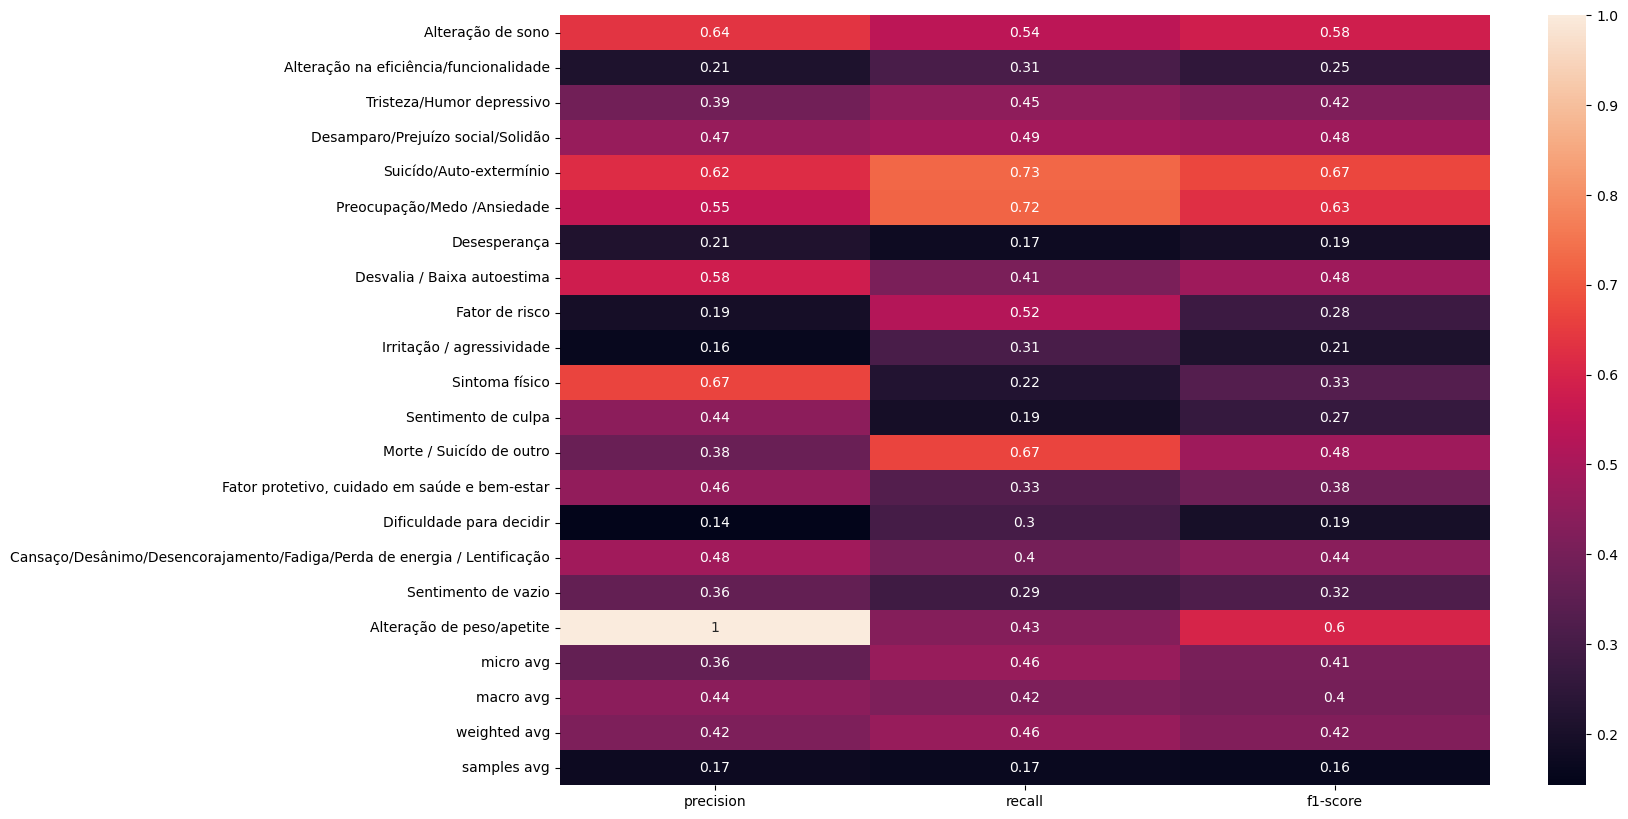

In [44]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(best_fine_tuning_report).iloc[:-1, :].T, annot=True)

# Analisando os casos de erro

primeiro olhando o sintomas que o model erra mais. Lembre-se: o essencial é conhecer os dados!

In [45]:
for i,symptom in enumerate(target_names):
    new = []
    for j,text in enumerate(test_df.text):
        row = {"text":text,"predicted":preds[i][j],"label":best_labels[j][i]}
        new.append(row)
    new = pd.DataFrame(new)
    new.to_csv(f"error analysis/baselines/{symptom.replace('/',' ')}.csv")
        
        
